## L2 norm estimation of the equivalent layer parameters

This notebook evaluates the predicted data obtained by an equivalent layer located at a specific depth.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from coord import GGS
from equiv_layer import EqLayer
from carto_map_plot import point_map
import config_style_plot as style

# Redefining functions
geodetic2cartesian = GGS().geodetic2cartesian
rotation_matrix = GGS().rotation_matrix
# Plot style
style.plot_params()

In [2]:
def L1_estim(rcl, pcl, Acc_l, it_max):
    for i in range(it_max):
#         print i
        res = rcl - np.dot(Acc_l, pcl)
        W = np.dot(Acc_l.T, np.diag(1./(np.abs(res)+1e-10)) )
        pcl = np.linalg.solve(np.dot(W, Acc_l), np.dot(W, rcl))
    return pcl

In [3]:
# IMPORTING BDG FILE
header=['LONG', 'LAT', 'ALT_GEOM', 'GRAV']
path = '../data/BDG/'
uf = 'RJ'
name_bdg = '_file.txt'
bdg = pd.read_csv('{p}{u}{ne}'.format(p=path,u=uf,ne=name_bdg), sep='\s+',names=header, skiprows=1)
# bdg

In [4]:
# IMPORTING EIGEN FILE
name_eigen = '.dat'
eigen = pd.read_csv('{p}{u}{ne}'.format(p=path,u=uf,ne=name_eigen), sep='\s+',skiprows=32, \
                    usecols=(4,), names=['GRAV'])
# eigen

In [5]:
# Obtaining short wavelength signals
disturb = bdg.GRAV.values - eigen.GRAV.values

data = {'LONG':bdg.LONG.values, \
        'LAT':bdg.LAT.values, \
        'ALT':bdg.ALT_GEOM.values, \
        'BDG':bdg.GRAV.values, \
        'EIGEN':eigen.GRAV.values, \
        'DIST':disturb}
df = pd.DataFrame(data)
df

,LONG,LAT,ALT,BDG,EIGEN,DIST
0,-44.02740,-22.58160,383.270,978656.86,978669.700995,-12.840995
1,-43.97770,-22.58130,433.420,978650.28,978656.531889,-6.251889
2,-43.93530,-22.60560,469.320,978648.69,978658.211839,-9.521839
3,-44.17110,-22.60250,404.470,978646.45,978662.746730,-16.296730
4,-44.15580,-22.64690,486.360,978638.46,978653.660398,-15.200398
...,...,...,...,...,...,...
2052,-43.07019,-22.64561,-0.311,978765.29,978764.562309,0.727691
2053,-42.98108,-22.80578,21.774,978766.80,978772.497049,-5.697049
2054,-43.71307,-22.64068,34.698,978742.53,978761.615697,-19.085697
2055,-41.91497,-22.49111,2.634,978760.35,978752.005541,8.344459


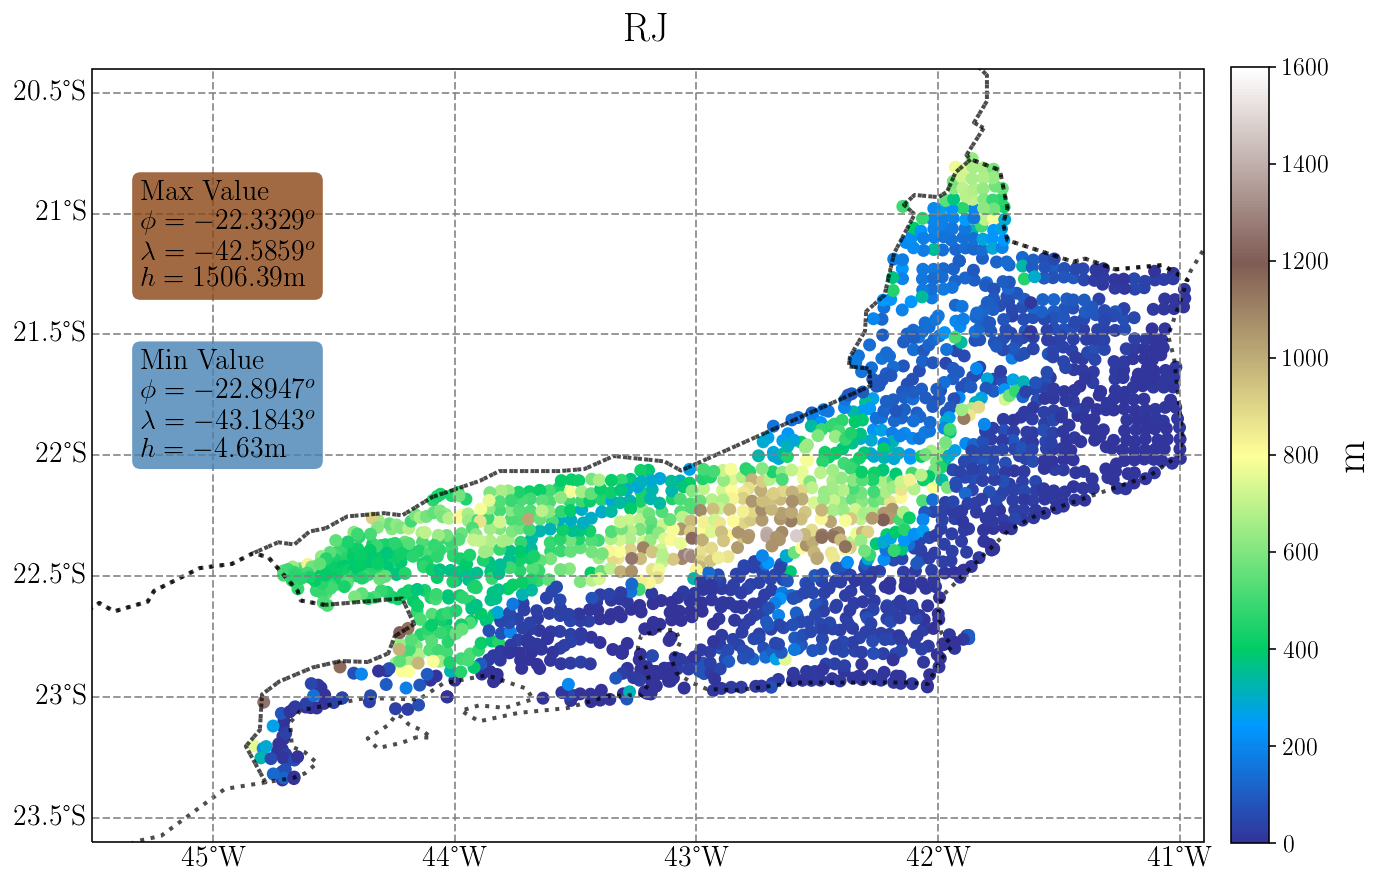

In [6]:
point_map(df.LONG, df.LAT, df.ALT, df.ALT, uf, fig_size=(12.,14.), region=[-45.5,-40.9,-23.6,-20.4], \
         cmap='terrain', sign=(-45.3,-45.3,-21.3,-22), lim_val=(True,True,0.,1600.))

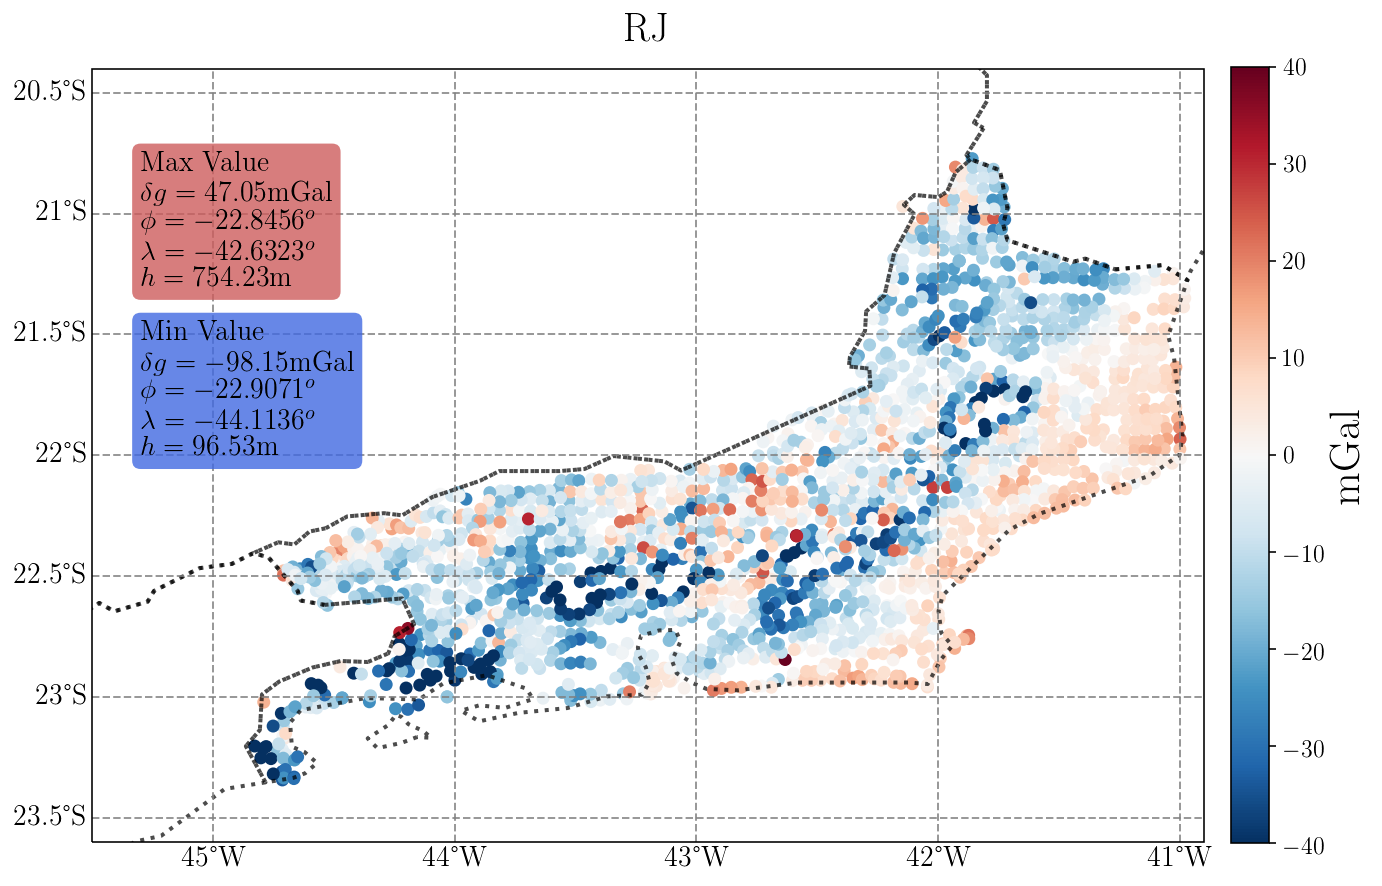

In [7]:
point_map(df.LONG, df.LAT, df.ALT, df.DIST, uf, fig_size=(12.,14.), region=[-45.5,-40.9,-23.6,-20.4], \
         sign=(-45.3,-45.3,-21.3,-22), lim_val=(True, 40.))

### Calculating rotation matrices and Cartesian coordinates

In [8]:
# Calculating Cartesian coordinates
x, y, z = geodetic2cartesian(df.LONG, df.LAT, df.ALT)
R = np.array(rotation_matrix(df.LONG, df.LAT))

## Estimating the first set of point-mass parameters

In [9]:
pc = []
hc = []
indc = []
xc = []
yc = []
zc = []
Rc = []
rabs_max = []
taur = 1e-11 #1e-5 #0.05
tauc = 1e-3
it_max_l1 = 5
latc = []
lonc = []

## Iteração 1 - L2 norm

In [10]:
indl = np.arange(disturb.size)
# mi_c = 1e-5
mi_c = 1e-30
hcl = 3000. #5000. #14200. # 20000. #800. #1000.
print(hcl, type(indl)) #indl

3000.0 <class 'numpy.ndarray'>


In [11]:
rcl = disturb[indl]
xcl = x[indl]
ycl = y[indl]
zcl = z[indl]

latcl = df.LAT[indl]
loncl = df.LONG[indl]

In [12]:
Rcl = R[:, indl]

In [13]:
# Calculo de Acc_l
hlay = np.zeros(indl.size) - hcl
xlay, ylay, zlay = geodetic2cartesian(loncl, latcl, hlay)
Lay = EqLayer(df.LONG, df.LAT, np.zeros_like(df.LONG)-hcl)
layer = Lay.build_layer(xlay, ylay, zlay)
Acc_l = Lay.designMat(xcl, ycl, zcl, Rcl, layer)
print(Acc_l.shape)

(2057, 2057)


In [14]:
H = np.dot(Acc_l.T, Acc_l)
# H += mi_c*np.trace(H)*np.identity(indl.size)
H += (mi_c*np.trace(H)*np.identity(indl.size))/indl.size

In [15]:
p_L2 = np.linalg.solve(H, np.dot(Acc_l.T, rcl))
print(p_L2.size)
# p_L1 = L1_estim(rcl, p_L2, Acc_l, 5)

2057


In [16]:
rcl -= np.dot(Acc_l, p_L2)
# print rcl[:50]

In [17]:
rabs_max_l = np.max(np.abs(rcl))
rabs_max_l

0.2470462246867995

In [18]:
pc.append(p_L2)
hc.append(hcl)
indc.append(indl)
xc.append(xcl)
yc.append(ycl)
zc.append(zcl)
Rc.append(Rcl)
latc.append(latcl)
lonc.append(loncl)

In [19]:
rabs_max.append(rabs_max_l)

In [20]:
rc = rcl[:] #r1
print(np.max(np.abs(rc)))

0.2470462246867995


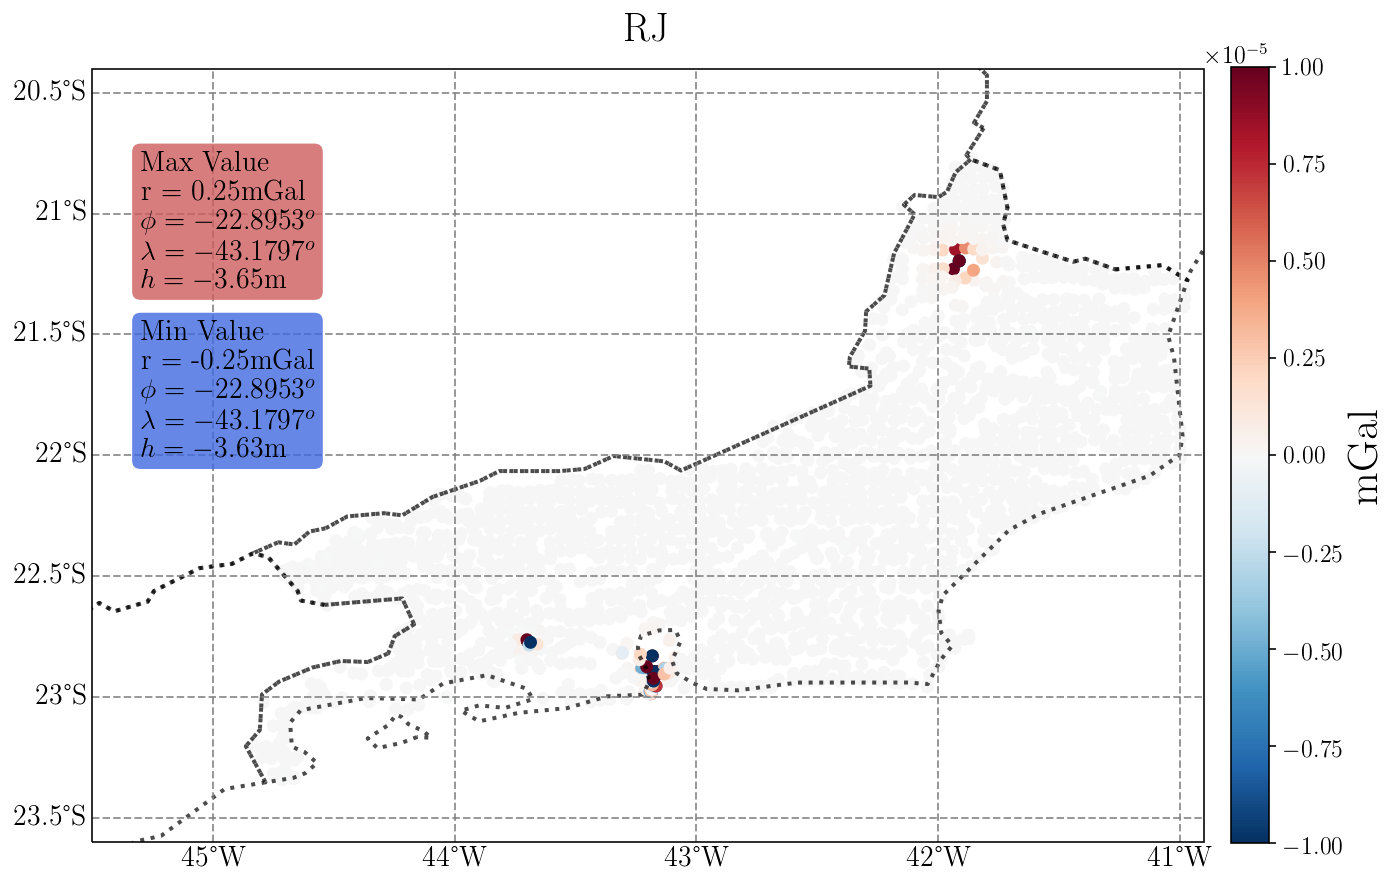

In [21]:
point_map(df.LONG, df.LAT, df.ALT, rc, uf, fig_size=(12.,14.), region=[-45.5,-40.9,-23.6,-20.4], \
         sign=(-45.3,-45.3,-21.3,-22), residual=True, lim_val=(True, 1e-5), \
          save='../figs/'+uf+'_res.png')

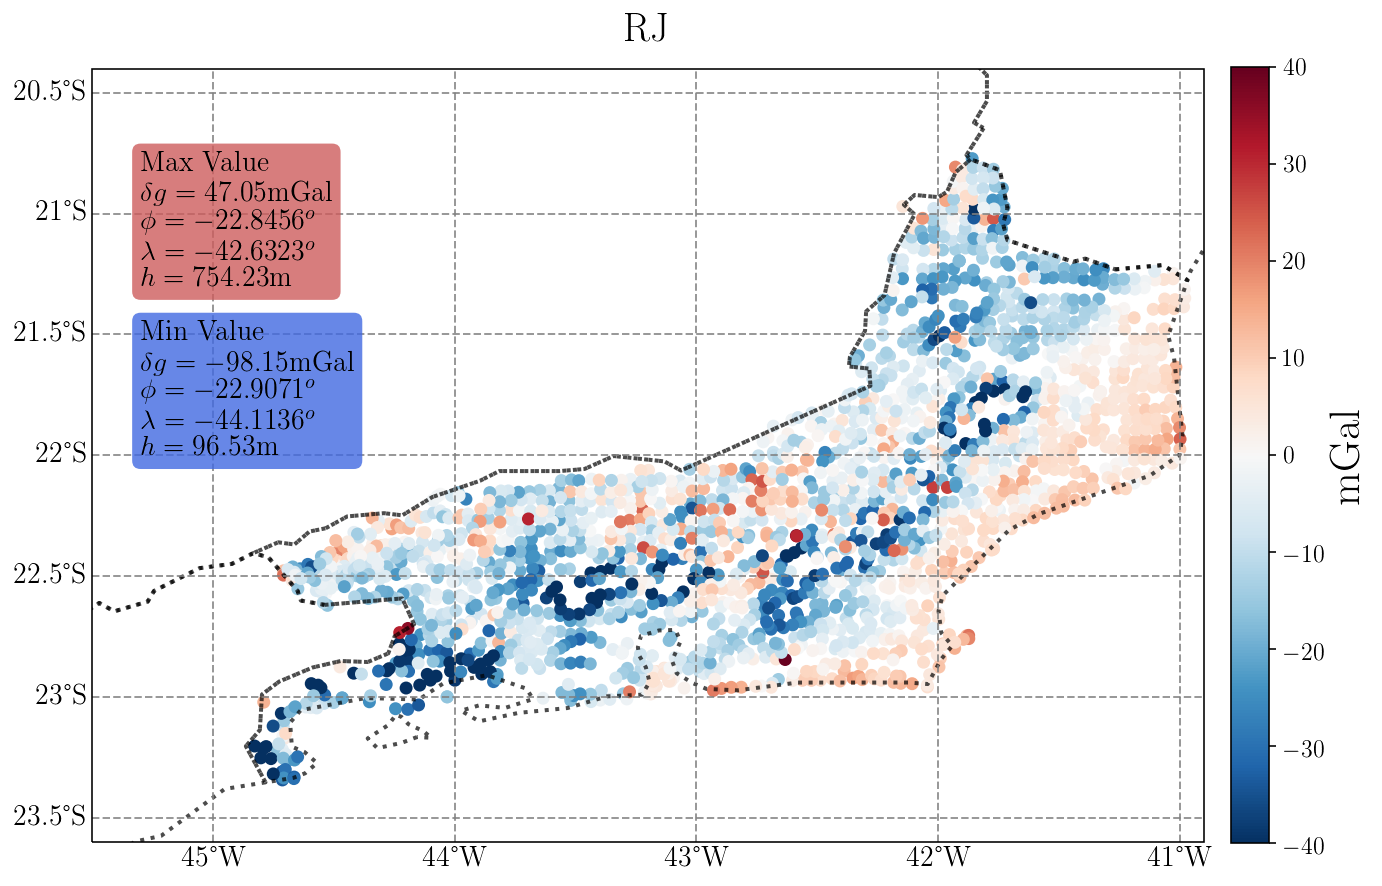

In [22]:
point_map(df.LONG, df.LAT, df.ALT, df.DIST, uf, fig_size=(12.,14.), region=[-45.5,-40.9,-23.6,-20.4], \
         sign=(-45.3,-45.3,-21.3,-22), lim_val=(True, 40.), \
          save='../figs/'+uf+'_dist.png')

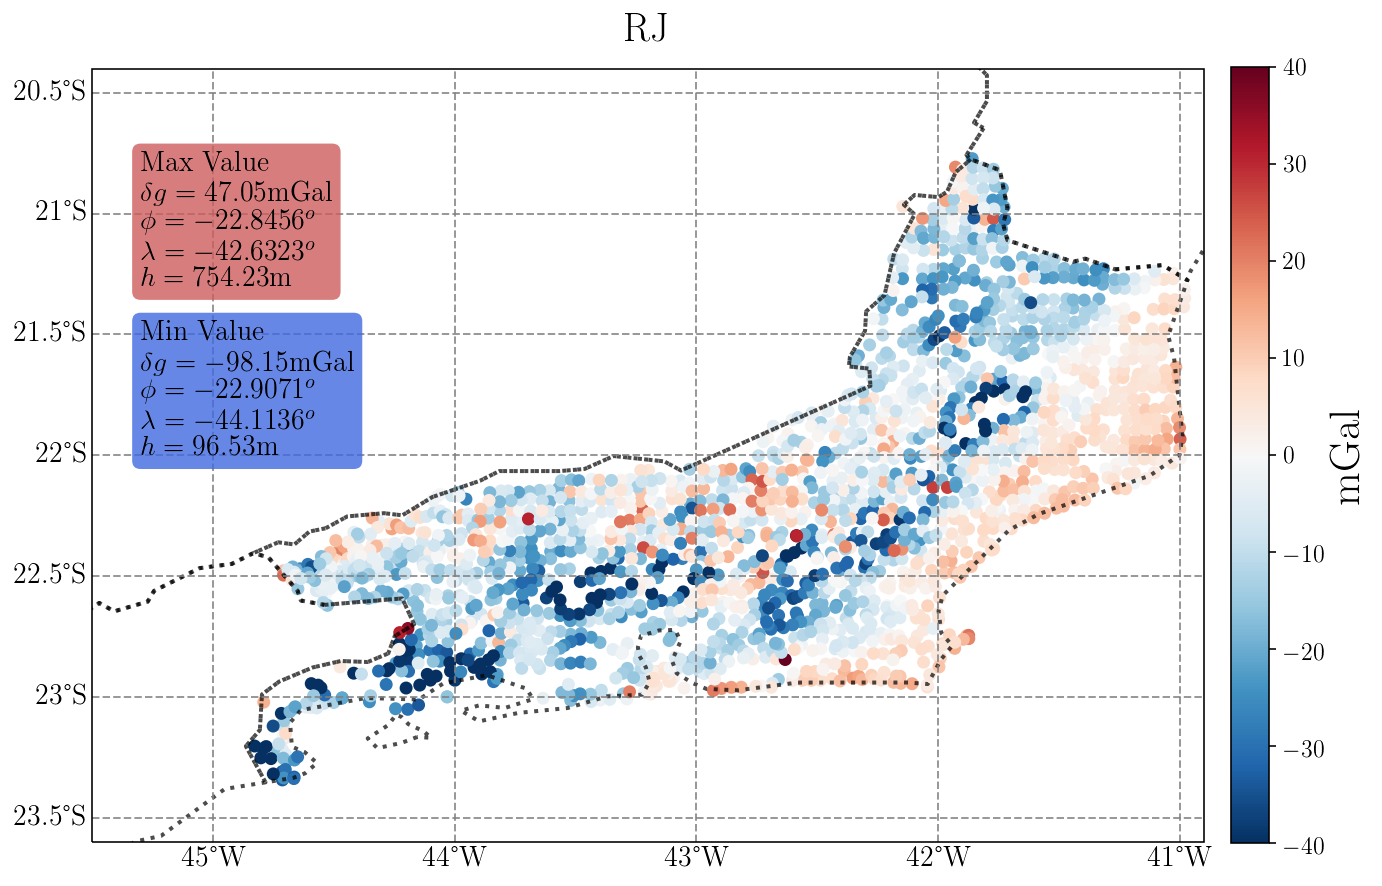

In [23]:
point_map(df.LONG, df.LAT, df.ALT, np.dot(Acc_l, p_L2), uf, fig_size=(12.,14.), \
          region=[-45.5,-40.9,-23.6,-20.4], sign=(-45.3,-45.3,-21.3,-22), lim_val=(True, 40.), \
          save='../figs/'+uf+'_pred.png')

In [24]:
print(len([value for value in rc if value > 1e-5]))
print([value for value in rc if value > 1e-5])

20
[0.014322600508079653, 0.006635914654102848, 0.022333620548523392, 2.1182359206228796e-05, 1.3248869509485672e-05, 3.763166019155051e-05, 8.492284618810686e-05, 0.00041655761829240134, 0.00022382737810566766, 0.0009948463365399007, 0.24630934545367955, 1.6400278985084782e-05, 1.0195962273584769e-05, 1.6346515201881573e-05, 1.250984000833455e-05, 0.00023111911577711197, 0.007031506126275566, 0.014745770771146027, 3.1492239647157305e-05, 0.01192625292530991]


In [25]:
new_data = {'LONG':bdg.LONG.values, \
            'LAT':bdg.LAT.values, \
            'ALT':bdg.ALT_GEOM.values, \
            'BDG':bdg.GRAV.values, \
            'EIGEN':eigen.GRAV.values, \
            'DIST':disturb, \
            'RHO':p_L2, \
            'RESID':rc}
df = pd.DataFrame(new_data)
df

,LONG,LAT,ALT,BDG,EIGEN,DIST,RHO,RESID
0,-44.02740,-22.58160,383.270,978656.86,978669.700995,-12.840995,1.089556e+11,4.890026e-10
1,-43.97770,-22.58130,433.420,978650.28,978656.531889,-6.251889,-2.486516e+12,6.740724e-10
2,-43.93530,-22.60560,469.320,978648.69,978658.211839,-9.521839,1.206297e+12,9.798420e-10
3,-44.17110,-22.60250,404.470,978646.45,978662.746730,-16.296730,-3.018433e+12,4.166694e-10
4,-44.15580,-22.64690,486.360,978638.46,978653.660398,-15.200398,-2.669895e+12,4.679173e-10
...,...,...,...,...,...,...,...,...
2052,-43.07019,-22.64561,-0.311,978765.29,978764.562309,0.727691,2.480627e+12,1.368422e-08
2053,-42.98108,-22.80578,21.774,978766.80,978772.497049,-5.697049,1.631692e+11,3.655341e-08
2054,-43.71307,-22.64068,34.698,978742.53,978761.615697,-19.085697,-1.317323e+12,6.013767e-09
2055,-41.91497,-22.49111,2.634,978760.35,978752.005541,8.344459,-2.822378e+12,-6.126655e-11


In [26]:
print(df.RESID.min(), df.RESID.max())

-0.2470462246867995 0.24630934545367955


### Upward Continuation

In [27]:
# up_cont = Lay.continuation(df.LONG,df.LAT,6000.,df.LONG,df.LAT,-3000.,p_L2)

In [28]:
Layer = EqLayer(df.LONG, df.LAT, np.zeros_like(df.LONG)-hcl)
up_cont = Layer.continuation(df.LONG,df.LAT,3000.,-3000.,p_L2)

The transformation is an upward continuation


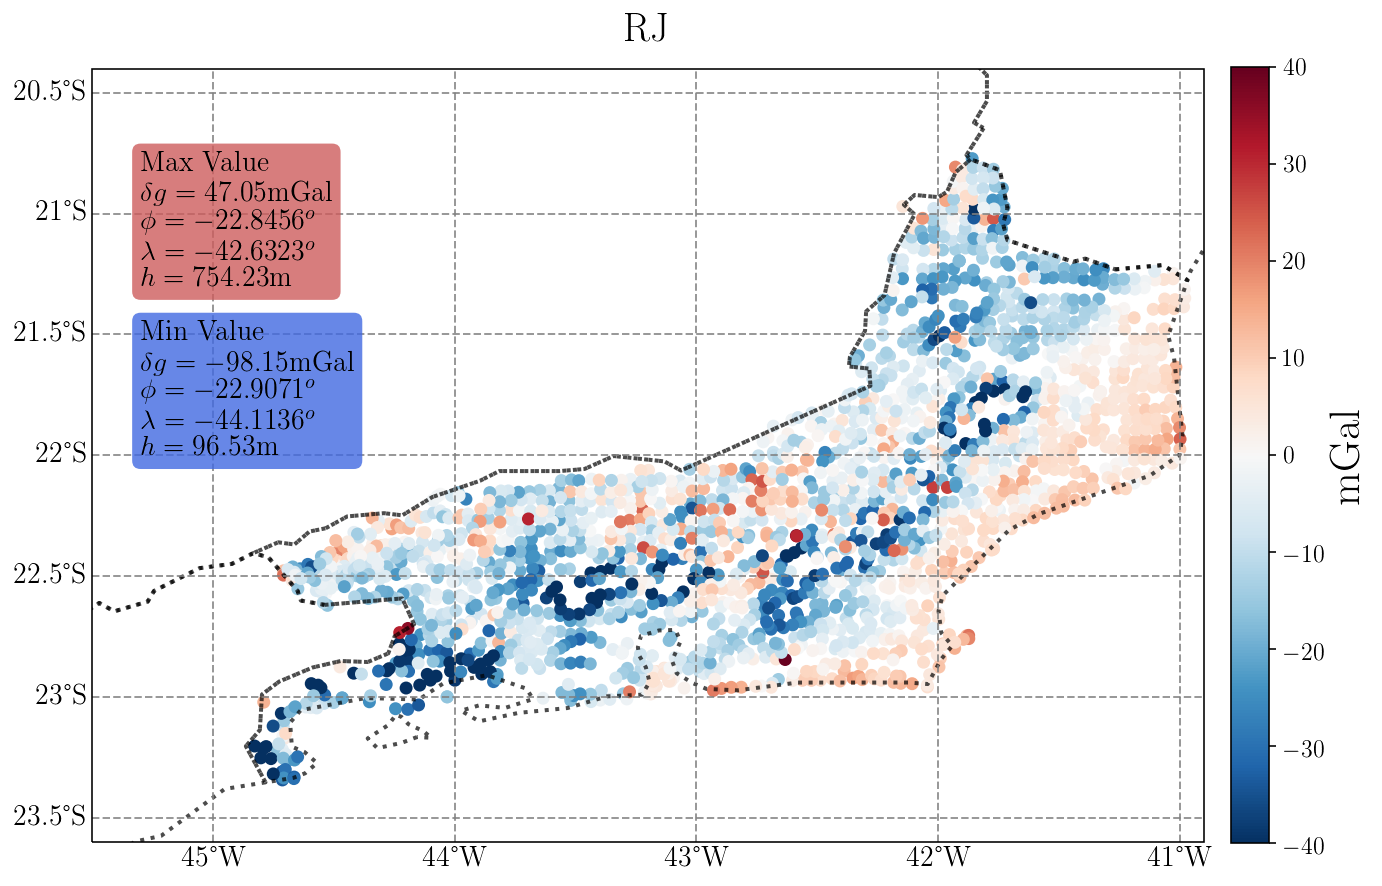

In [29]:
point_map(df.LONG, df.LAT, df.ALT, df.DIST, uf, fig_size=(12.,14.), region=[-45.5,-40.9,-23.6,-20.4], \
         sign=(-45.3,-45.3,-21.3,-22), lim_val=(True, 40.))

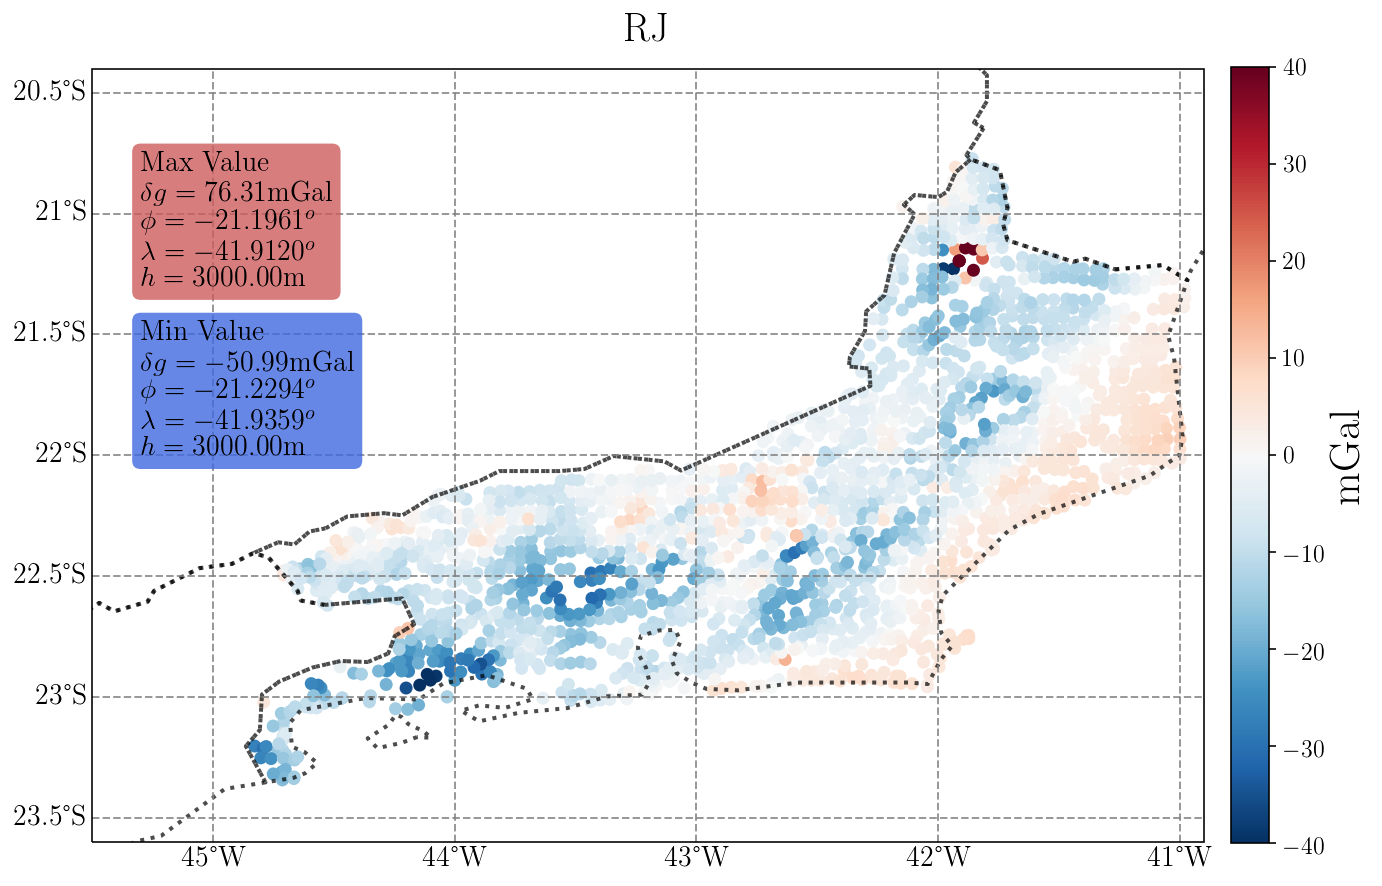

In [30]:
point_map(df.LONG, df.LAT, np.zeros_like(df.LONG)+3000., up_cont, uf, fig_size=(12.,14.), \
          region=[-45.5,-40.9,-23.6,-20.4], sign=(-45.3,-45.3,-21.3,-22), lim_val=(True, 40.))

In [31]:
Layer = EqLayer(df.LONG, df.LAT, np.zeros_like(df.LONG)-hcl)
up_cont = Layer.continuation(df.LONG,df.LAT,6000.,-3000.,p_L2)

The transformation is an upward continuation


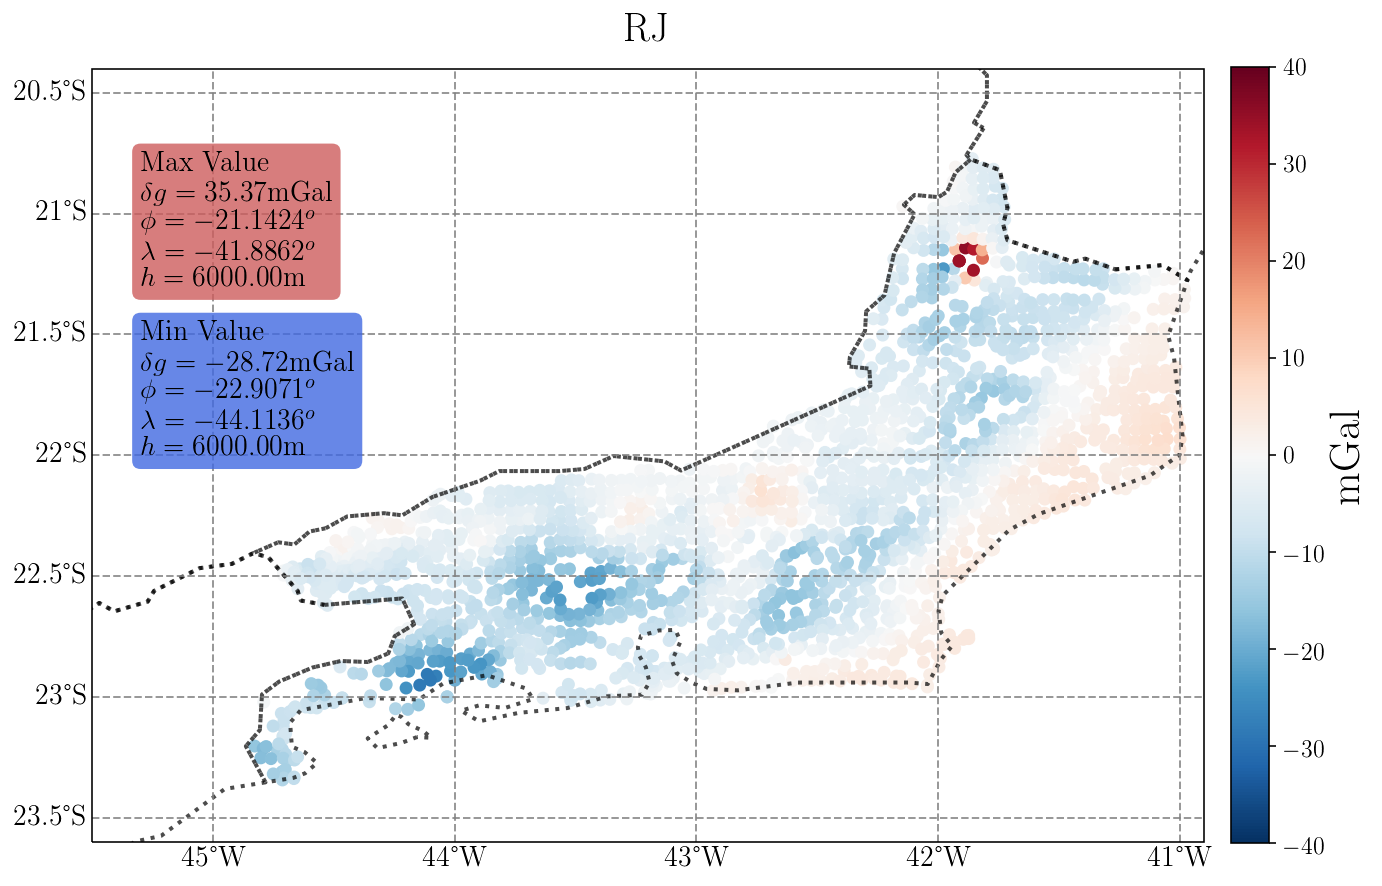

In [32]:
point_map(df.LONG, df.LAT, np.zeros_like(df.LONG)+6000., up_cont, uf, fig_size=(12.,14.), \
          region=[-45.5,-40.9,-23.6,-20.4], sign=(-45.3,-45.3,-21.3,-22), lim_val=(True, 40.), \
          save='../figs/'+uf+'_pred'+str(6000)+'.png')

In [33]:
Layer = EqLayer(df.LONG, df.LAT, np.zeros_like(df.LONG)-hcl)
up_cont = Layer.continuation(df.LONG,df.LAT,9000.,-3000.,p_L2)

The transformation is an upward continuation


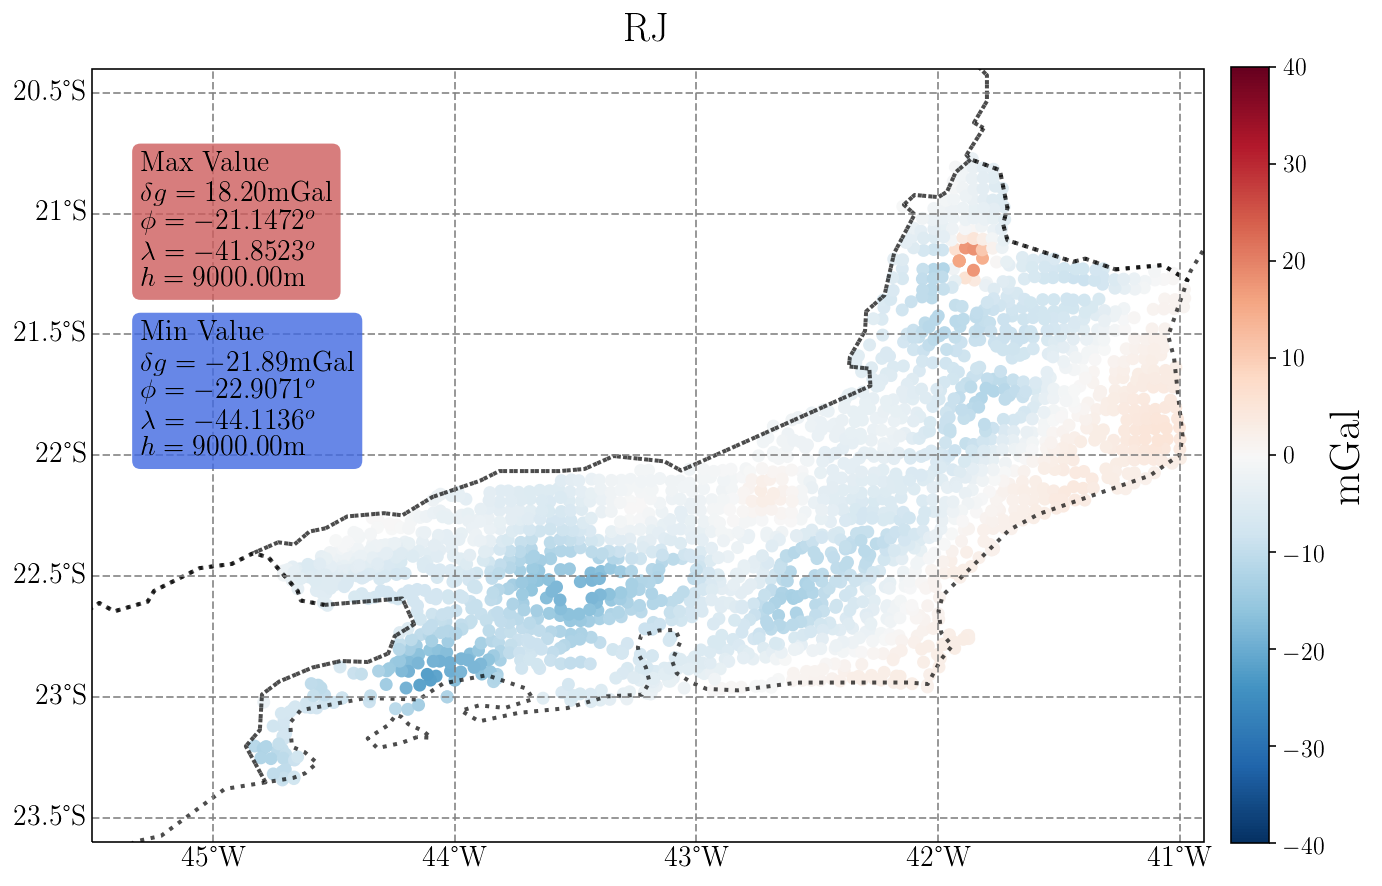

In [34]:
point_map(df.LONG, df.LAT, np.zeros_like(df.LONG)+9000., up_cont, uf, fig_size=(12.,14.), \
          region=[-45.5,-40.9,-23.6,-20.4], sign=(-45.3,-45.3,-21.3,-22), lim_val=(True, 40.), \
          save='../figs/'+uf+'_pred'+str(9000)+'.png')